2024-12-07 02:23:40.448001: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-12-07 02:23:40.448033: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-12-07 02:23:40.448036: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-12-07 02:23:40.448229: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-07 02:23:40.448241: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2024-12-07 02:23:41.602836: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


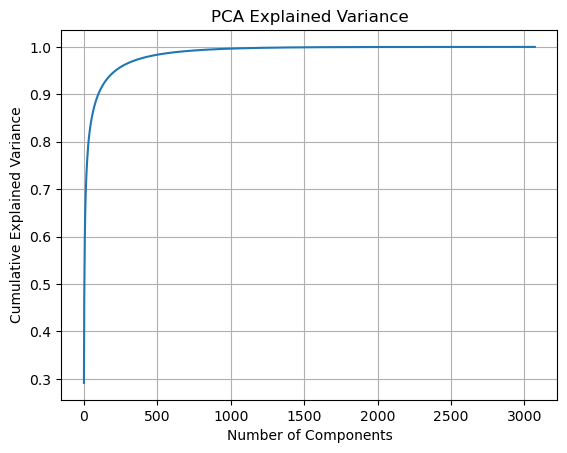

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

# Load CIFAR-10 dataset and split into training, validation, and test sets
train_ds = tfds.load('cifar10', split='train[:40000]', as_supervised=True)
val_ds = tfds.load('cifar10', split='train[40000:]', as_supervised=True)
test_ds = tfds.load('cifar10', split='test', as_supervised=True)

# Batch the dataset
batch_size = 32
train_ds = train_ds.batch(batch_size)

# Flatten images for PCA
def flatten_images(dataset):
    images = []
    labels = []
    for image_batch, label_batch in dataset:
        images.append(image_batch.numpy().reshape(image_batch.shape[0], -1))  # Flatten to 2D
        labels.append(label_batch.numpy())
    return np.concatenate(images), np.concatenate(labels)

train_images, train_labels = flatten_images(train_ds)

# Apply PCA
pca = PCA()
pca.fit(train_images)

# Visualize explained variance
explained_variance = np.cumsum(pca.explained_variance_ratio_)

plt.plot(explained_variance)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.grid(True)
plt.show()


In [2]:
# Select top 10 and top 5 components
n_components_10 = 200

pca_10 = PCA(n_components=n_components_10)

train_images_10 = pca_10.fit_transform(train_images)

# Reconstruct images
train_images_reconstructed_10 = pca_10.inverse_transform(train_images_10)

# Reshape to original dimensions
train_images_reconstructed_10 = train_images_reconstructed_10.reshape(-1, 32, 32, 3)
train_images = train_images.reshape((-1, 32, 32, 3))  # (800, 32, 32, 3)

In [3]:
# Convert reconstructed images and labels to a tf.data.Dataset
train_dataset_pca = tf.data.Dataset.from_tensor_slices((train_images_reconstructed_10, train_labels))

# Preprocess the images for training, validation, and testing
def preprocess(image, label):
    image = tf.image.resize(image, (224, 224))  # Resize image to MobileNetV2 input size
    image = image / 255.0  # Normalize image to range [0, 1]
    return image, label

# Apply preprocessing and batch the datasets
batch_size = 32
train_dataset_pca = train_dataset_pca.map(preprocess).batch(batch_size).prefetch(tf.data.AUTOTUNE)


In [4]:
val_ds = val_ds.map(preprocess).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.map(preprocess).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Load MobileNetV2 base model and modify for CIFAR-10
base_model = tf.keras.applications.MobileNetV2(
    weights='imagenet', 
    input_shape=(224, 224, 3), 
    include_top=False
)

# Freeze the base model
base_model.trainable = False

# Create the model
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(10, activation='softmax')  # CIFAR-10 has 10 classes
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',       # Metric to monitor (e.g., validation loss)
    patience=10,              # Number of epochs with no improvement after which training will stop
    restore_best_weights=True # Restore model weights from the epoch with the best value of the monitored metric
)

# Train the model with validation data
print("Training the model on CIFAR-10 images...")
model.fit(train_dataset_pca, validation_data=val_ds, epochs=100, callbacks=[early_stopping])

# Save the trained model
model.save('mobilenet_cifar10_pca500.h5')
print("Model saved successfully.")

Training the model on CIFAR-10 images...
Epoch 1/10


2024-12-07 02:27:06.982500: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 246s 193ms/step - accuracy: 0.4275 - loss: 1.6153 - val_accuracy: 0.4003 - val_loss: 2.0164
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 247s 198ms/step - accuracy: 0.5521 - loss: 1.2756 - val_accuracy: 0.4313 - val_loss: 1.9751
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 263s 210ms/step - accuracy: 0.5747 - loss: 1.2150 - val_accuracy: 0.4511 - val_loss: 1.9822
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 270s 216ms/step - accuracy: 0.5859 - loss: 1.1799 - val_accuracy: 0.4553 - val_loss: 2.0119
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 250s 200ms/step - accuracy: 0.5960 - loss: 1.1554 - val_accuracy: 0.4593 - val_loss: 2.0505
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 258s 207ms/step - accuracy: 0.6034 - loss: 1.1368 - val_accuracy: 0.4588 - val_loss: 2.0919
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 276s 221ms/step - accuracy: 0.6078 - loss: 1.1219 - val_accuracy: 0.4580 - val_loss: 2.1339
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 296s 236ms/step - accuracy: 0.6

Model saved successfully.


In [ ]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test accuracy: {test_accuracy * 100:.2f}%")

313/313 ━━━━━━━━━━━━━━━━━━━━ 50s 160ms/step - accuracy: 0.4557 - loss: 2.2547
Test accuracy: 45.35%
